In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/riiid-test-answer-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [2]:
import riiideducation

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
import lightgbm as lgb
from lightgbm import LGBMClassifier
import eli5



%matplotlib inline
# for heatmap and other plots
colorMap1 = sns.color_palette("RdBu_r")
# for countplot and others plots
colorMap2 = 'Blues_r'

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
train_path = "/kaggle/input/riiid-test-answer-prediction/train.csv"
questions_path = "../input/riiid-test-answer-prediction/questions.csv"
lectures_path = "../input/riiid-test-answer-prediction/lectures.csv"
test = "../input/riiid-test-answer-prediction/example_test.csv"

# **DATA EXPLORATION & EDA**

We used the 5% of the data

In [4]:
%%time

train = pd.read_csv(train_path, low_memory=False,  nrows=10123033,
                       dtype={'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 'content_type_id': 'int8',
                              'task_container_id': 'int16', 'user_answer': 'int8', 'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                             'prior_question_had_explanation': 'boolean',
                             }
                      )
train

CPU times: user 21.3 s, sys: 1.95 s, total: 23.3 s
Wall time: 27.5 s


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
10123028,10123028,157429652,219543270,2121,0,88,3,0,36667.0,True
10123029,10123029,157429652,219543270,2120,0,88,1,0,36667.0,True
10123030,10123030,157429652,219543270,2122,0,88,3,1,36667.0,True
10123031,10123031,157745849,219543270,1795,0,89,2,1,36667.0,True


In [5]:
print(f"Train shape: {train.shape}")

Train shape: (10123033, 10)


In [6]:
train.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
5,5,157063,115,156,0,5,2,1,5000.0,False
6,6,176092,115,51,0,6,0,1,17000.0,False
7,7,194190,115,50,0,7,3,1,17000.0,False
8,8,212463,115,7896,0,8,2,1,16000.0,False
9,9,230983,115,7863,0,9,0,1,16000.0,False


In [7]:
print(train.isnull().sum())

row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       237438
prior_question_had_explanation     39821
dtype: int64


In [8]:
train=train.dropna()

In [9]:
print(train.shape)

(9885595, 10)


In [10]:
print(train.isnull().sum())

row_id                            0
timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64


In [11]:
train.memory_usage()

Index                             79084760
row_id                            79084760
timestamp                         79084760
user_id                           39542380
content_id                        19771190
content_type_id                    9885595
task_container_id                 19771190
user_answer                        9885595
answered_correctly                 9885595
prior_question_elapsed_time       39542380
prior_question_had_explanation    19771190
dtype: int64

In [12]:
train.drop(['row_id', 'timestamp'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
train.describe().style.background_gradient(cmap='Blues')

,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,9885595.000000,9885595.000000,9885595.000000,9885595.000000,9885595.000000,9885595.000000,9885595.000000
mean,109339453.072281,4977.612804,0.000000,887.767714,1.425652,0.658507,25316.494141
std,63881722.815432,3286.962608,0.000000,1348.642885,1.156551,0.474210,19685.593750
min,115.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54713154.000000,1987.000000,0.000000,103.000000,0.000000,0.000000,16000.000000
50%,108451478.000000,4978.000000,0.000000,375.000000,1.000000,1.000000,21000.000000
75%,165342103.000000,7217.000000,0.000000,1066.000000,3.000000,1.000000,29666.000000
max,219543270.000000,13522.000000,0.000000,9999.000000,3.000000,1.000000,300000.000000


In [14]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,9885595.0,1.093395e+08,6.388172e+07,115.0,54713154.0,108451478.0,165342103.0,219543270.0
content_id,9885595.0,4.977613e+03,3.286963e+03,0.0,1987.0,4978.0,7217.0,13522.0
content_type_id,9885595.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
task_container_id,9885595.0,8.877677e+02,1.348643e+03,0.0,103.0,375.0,1066.0,9999.0
user_answer,9885595.0,1.425652e+00,1.156551e+00,0.0,0.0,1.0,3.0,3.0
answered_correctly,9885595.0,6.585074e-01,4.742103e-01,0.0,0.0,1.0,1.0,1.0
prior_question_elapsed_time,9885595.0,2.531649e+04,1.968559e+04,0.0,16000.0,21000.0,29666.0,300000.0


In [15]:
train['answered_correctly'].describe()

count    9.885595e+06
mean     6.585074e-01
std      4.742103e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: answered_correctly, dtype: float64

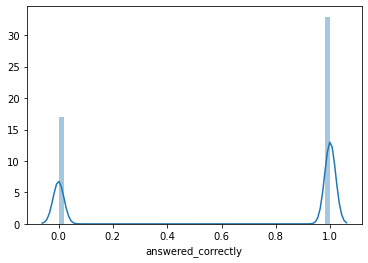

In [16]:
sns.distplot(train['answered_correctly']);

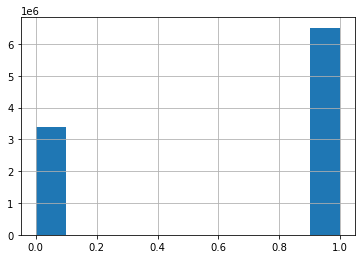

In [17]:
train['answered_correctly'].hist()

In [18]:
feature = ['answered_correctly','user_id', 'content_id', 'task_container_id',
       'user_answer', 'prior_question_elapsed_time','prior_question_had_explanation']
df = train[feature]

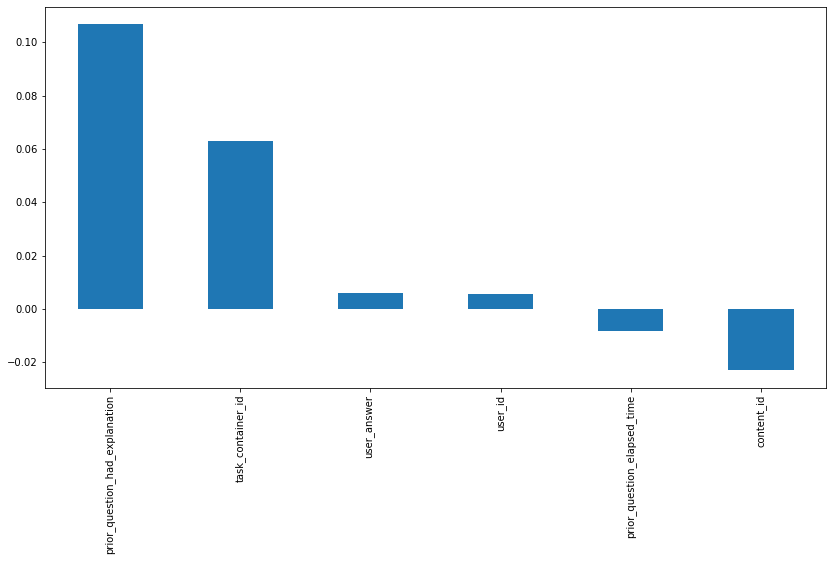

In [19]:
corr_with_target = df.corr()["answered_correctly"].sort_values(ascending=False)
plt.figure(figsize=(14,7))
corr_with_target.drop("answered_correctly").plot.bar()
plt.show()

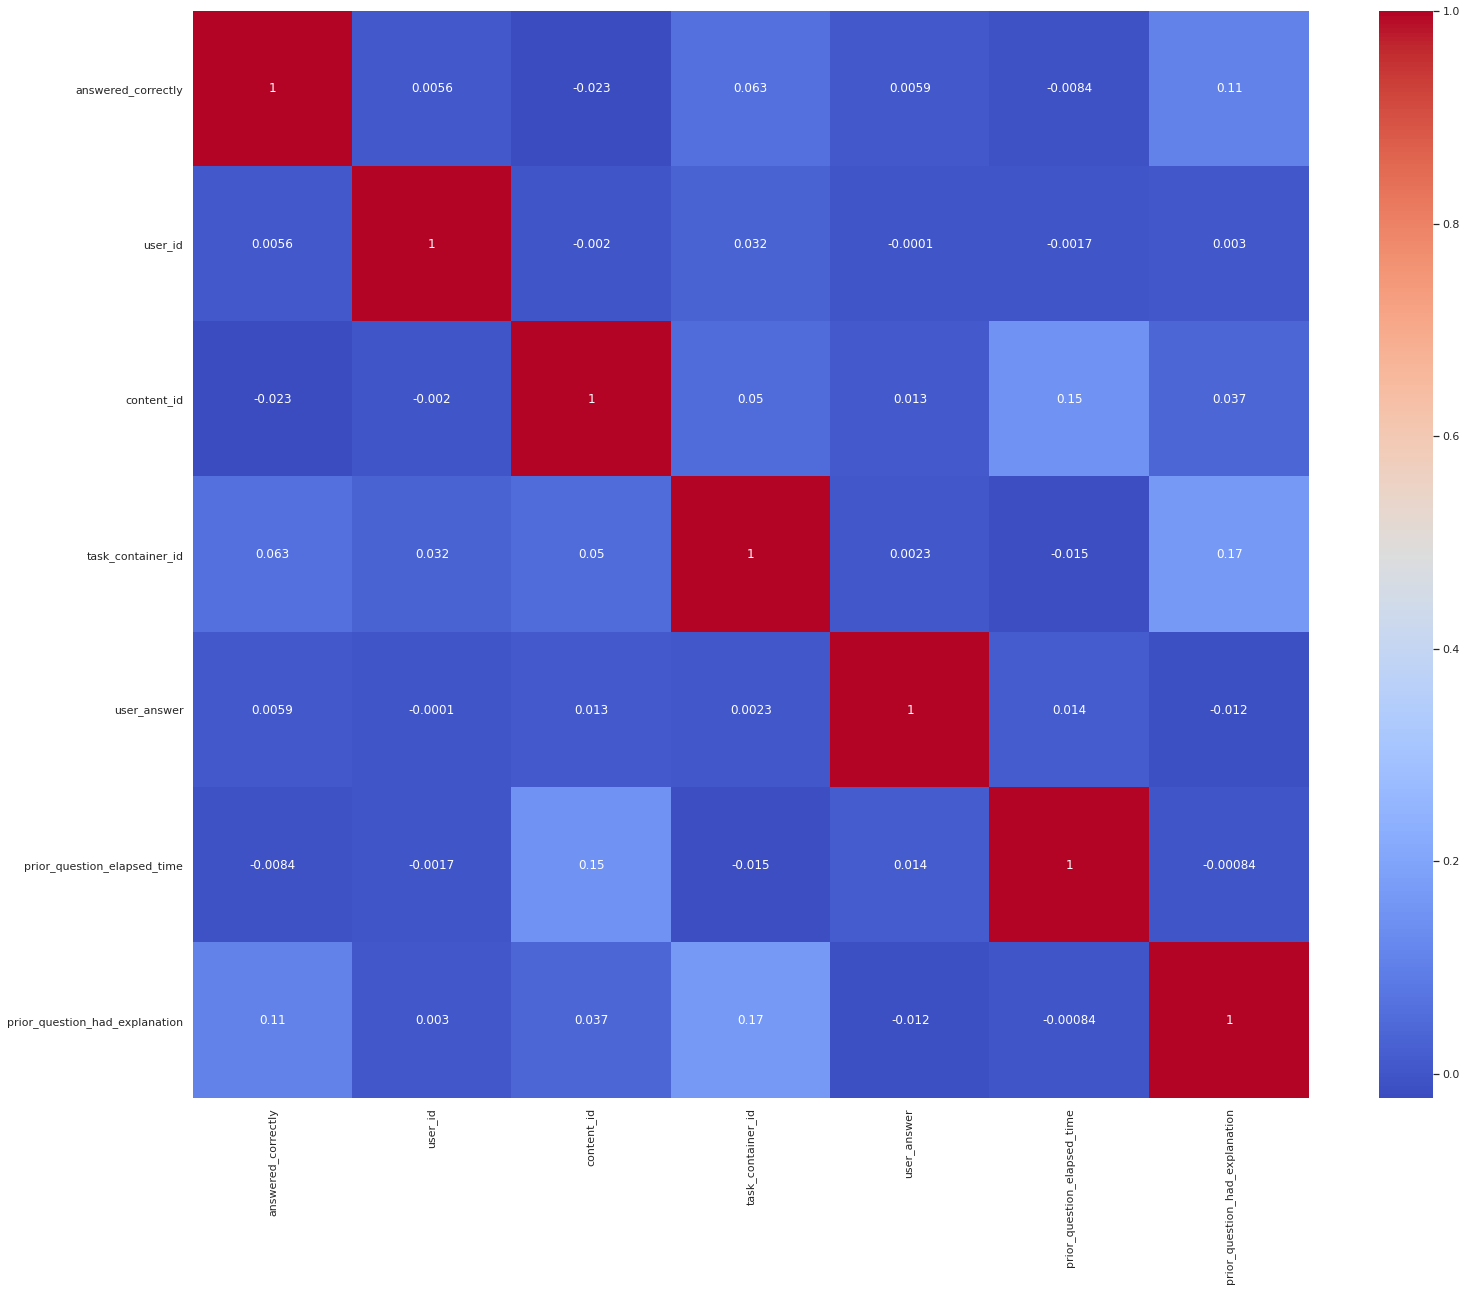

In [20]:
plt.figure(figsize=(25,20))
sns.set(font_scale=1)
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

In [21]:
correlation_matrix  = df.corr()
correlation_matrix["answered_correctly"].sort_values(ascending=False)

answered_correctly                1.000000
prior_question_had_explanation    0.106719
task_container_id                 0.062918
user_answer                       0.005889
user_id                           0.005571
prior_question_elapsed_time      -0.008384
content_id                       -0.023037
Name: answered_correctly, dtype: float64

# Features

I'll give just some part from our data bacause of the RAM limit on Kaggle kernel

In [22]:
n = int(train.shape[0] * 1)
train_n = train.sample(n=n, random_state=42)
n

9885595

In [23]:
user_characteristics = train.groupby('user_id').agg({'answered_correctly':
                                                  ['mean', 'median', 'std', 'skew', 'count']})
user_characteristics.columns = [
    'mean_user_acc',
    'median_user_acc',
    'std_user_acc',
    'skew_user_acc',
    'number_of_answered_q'
]

In [24]:
user_characteristics.head(5)

,mean_user_acc,median_user_acc,std_user_acc,skew_user_acc,number_of_answered_q
user_id,,,,,
115,0.688889,1.0,0.468179,-0.844439,45
124,0.206897,0.0,0.412251,1.527297,29
2746,0.611111,1.0,0.501631,-0.498374,18
5382,0.669355,1.0,0.472354,-0.728823,124
8623,0.638889,1.0,0.482562,-0.586492,108


In [25]:
task_container_characteristics = train.groupby('task_container_id').agg({'answered_correctly':
                                                                      ['mean', 'median', 'std', 'skew', 'count']})
task_container_characteristics.columns = [
    'mean_task_acc',
    'median_task_acc',
    'std_task_acc',
    'skew_task_acc',
    'number_of_asked_task_containers'
]

In [26]:
task_container_characteristics.head(5)

,mean_task_acc,median_task_acc,std_task_acc,skew_task_acc,number_of_asked_task_containers
task_container_id,,,,,
0,0.710069,1.0,0.454124,-0.928386,576
1,0.527815,1.0,0.499232,-0.111438,39906
2,0.435878,0.0,0.495877,0.258635,40064
3,0.543738,1.0,0.498090,-0.175630,40080
4,0.481363,0.0,0.499656,0.074599,69997


In [27]:
content_characteristics = train.groupby('content_id').agg({'answered_correctly':
                                                        ['mean', 'median', 'std', 'skew', 'count']})
content_characteristics.columns = [
    'mean_acc',
    'median_acc',
    'std_acc',
    'skew_acc',
    'number_of_asked_q'
]

In [28]:
content_characteristics.head(5)

,mean_acc,median_acc,std_acc,skew_acc,number_of_asked_q
content_id,,,,,
0,0.909220,1.0,0.287500,-2.854844,705
1,0.893878,1.0,0.308204,-2.562927,735
2,0.562061,1.0,0.496188,-0.250263,4560
3,0.779801,1.0,0.414471,-1.351330,2307
4,0.627936,1.0,0.483431,-0.529616,3193


In [29]:
train = train_n.copy()
del train_n

In [30]:
train = train.merge(user_characteristics, how='left', on='user_id')
train = train.merge(task_container_characteristics, how='left', on='task_container_id')
train = train.merge(content_characteristics, how='left', on='content_id')

# The target: answered_correctly

Answered_correctly is our target, and we have to predict to probability for an answer to be correct. 

In [31]:
features = [
    'prior_question_elapsed_time', 
    'prior_question_had_explanation',
    'mean_user_acc',
    'median_user_acc',
    'std_user_acc',
    'skew_user_acc',
    'number_of_answered_q',
    'mean_task_acc',
    'median_task_acc',
    'std_task_acc',
    'skew_task_acc',
    'number_of_asked_task_containers',
    'mean_acc',
    'median_acc',
    'std_acc',
    'skew_acc',
    'number_of_asked_q'
]

target = 'answered_correctly'


Drop features that we are not going to use in our model

In [32]:
col_to_drop = set(train.columns.values.tolist()).difference(features + [target])
for col in col_to_drop:
    del train[col]

In [33]:
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(value=False).astype(bool)
train = train.fillna(value=0.5)

In [34]:
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0.5)

In [35]:
train.head(5)

,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_user_acc,median_user_acc,std_user_acc,skew_user_acc,number_of_answered_q,mean_task_acc,median_task_acc,std_task_acc,skew_task_acc,number_of_asked_task_containers,mean_acc,median_acc,std_acc,skew_acc,number_of_asked_q
0,1,17000.0,True,0.836659,1.0,0.369690,-1.821562,13934,0.634146,1.0,0.484633,-0.567440,82,0.854291,1.0,0.352990,-2.011388,1002
1,0,17000.0,True,0.693439,1.0,0.461148,-0.839545,2789,0.700908,1.0,0.458020,-0.878519,1431,0.861991,1.0,0.345105,-2.102618,884
2,1,26500.0,True,0.733434,1.0,0.442275,-1.056666,1992,0.682195,1.0,0.465662,-0.782787,5903,0.719836,1.0,0.449539,-0.982070,489
3,1,10000.0,True,0.733903,1.0,0.442041,-1.059493,1755,0.672478,1.0,0.469336,-0.735155,8833,0.650185,1.0,0.477206,-0.630996,809
4,1,27000.0,True,0.788396,1.0,0.408461,-1.412325,13237,0.666667,1.0,0.472599,-0.712516,198,0.928721,1.0,0.257560,-3.343113,477


# Model

In [36]:
train_df, test_df, y_train, y_test = train_test_split(train[features], train[target], random_state=777, test_size=0.3)

1. **LGBMClassifier**

In [37]:
# clf = LGBMClassifier(random_state=777)

#params = {
#   'n_estimators': [50, 150, 300],'max_depth': [3, 5, 10],'num_leaves': [5, 15, 30],'min_data_in_leaf': [5, 50, 100],
#    'feature_fraction': [0.1, 0.5, 1.],'lambda': [0., 0.5, 1.],
#}
#cv = RandomizedSearchCV(clf, param_distributions=params, cv=5, n_iter=50, verbose=2)
#cv.fit(train_df, y_train)

#print(cv.best_params_)
#print(cv.best_score_)

In [38]:
params = {
    'num_leaves': 30, 
    'n_estimators': 300, 
    'min_data_in_leaf': 100, 
    'max_depth': 5, 
    'lambda': 0.0, 
    'feature_fraction': 1.0
}

In [39]:
model = LGBMClassifier(**params)
model.fit(train_df, y_train)

LGBMClassifier(feature_fraction=1.0, lambda=0.0, max_depth=5,
               min_data_in_leaf=100, n_estimators=300, num_leaves=30)

In [40]:
print('LGB ROC-AUC score: ', roc_auc_score(y_test.values, model.predict_proba(test_df)[:, 1]))
accuracy1=roc_auc_score(y_test.values, model.predict_proba(test_df)[:, 1])

LGB ROC-AUC score:  0.76009346135813


In [41]:
eli5.show_weights(model, top=20)

Weight,Feature
0.5617,mean_acc
0.2045,skew_user_acc
0.0731,skew_acc
0.0586,std_acc
0.0377,mean_user_acc
0.0123,std_user_acc
0.0112,number_of_answered_q
0.0108,number_of_asked_q
0.0104,median_acc
0.0080,prior_question_elapsed_time


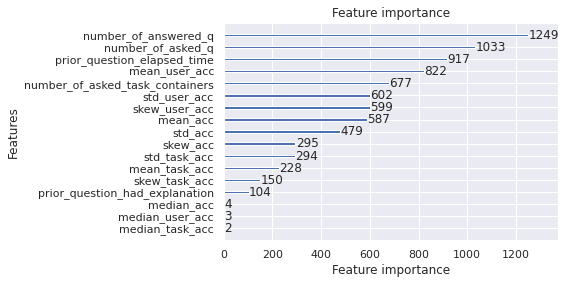

In [42]:
lgb.plot_importance(model)

2. **LogisticRegression**

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
logreg = LogisticRegression()

In [45]:
logreg.fit(train_df, y_train)

LogisticRegression()

Predicting the test set results and calculating the accuracy

In [58]:
y_pred = logreg.predict(test_df)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_df, y_test)))
accuracy2= logreg.score(test_df, y_test)

ValueError: could not convert string to float: '[1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]'

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 208239  804476]
 [ 108660 1844304]]


**The result is telling us that we have 208239+1844304 correct predictions and 804476+108660  incorrect predictions.**

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.21      0.31   1012715
           1       0.70      0.94      0.80   1952964

    accuracy                           0.69   2965679
   macro avg       0.68      0.57      0.56   2965679
weighted avg       0.68      0.69      0.63   2965679



**The support is the number of occurrences of each class in y_test.**

ROC Curve

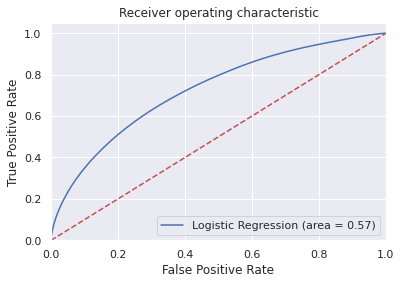

In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(test_df))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(test_df)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

3. **RandomForestClassifier**

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_df, y_train)
clf_pred = clf.predict(test_df)
print('Accuracy of Random Forest Classifier on test set: {:.4f}'.format(clf.score(test_df, y_test)))

In [52]:
accuracy3= clf.score(test_df, y_test)

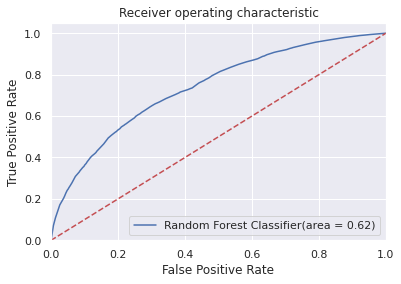

In [53]:
clf_roc_auc = roc_auc_score(y_test, clf.predict(test_df))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(test_df)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Classifier(area = %0.2f)' % clf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('clf_ROC')
plt.show()

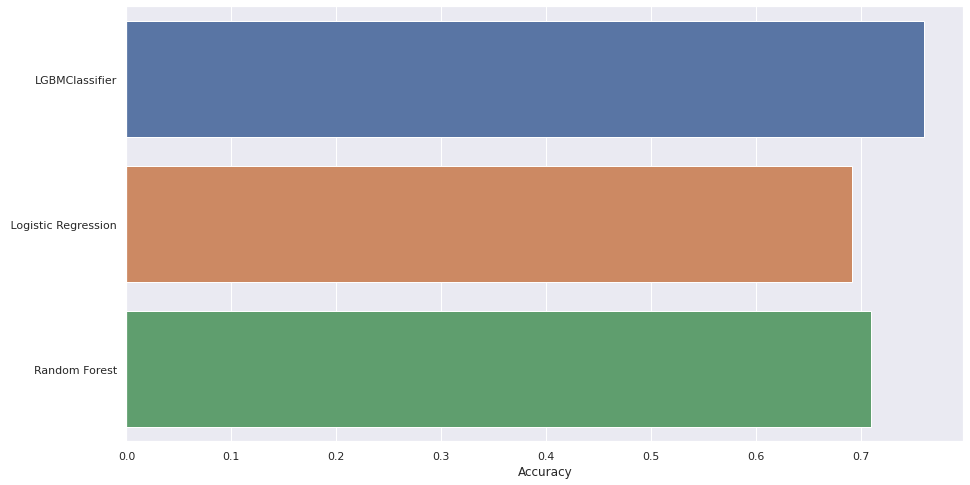

In [54]:
leaderboard  = pd.DataFrame({'Accuracy':[accuracy1,accuracy2, accuracy3]},index = ['LGBMClassifier', ' Logistic Regression', 'Random Forest'])
fig_dims = (15, 8)

fig, a = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="Accuracy", y=leaderboard.index, data=leaderboard,ax=a)

# SUBMISSION 

In [55]:
env = riiideducation.make_env()

In [56]:
iter_test = env.iter_test()

In [57]:
for (test_df, sample_prediction_df) in iter_test:
    # merge
    test_df = test_df.merge(user_characteristics, on = "user_id", how = "left")
    test_df = test_df.merge(task_container_characteristics, on = "task_container_id", how = "left")
    test_df = test_df.merge(content_characteristics, on = "content_id", how = "left")
    
    # type transformation
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(value=False).astype(bool)
    test_df.fillna(value = 0.5, inplace = True)
    test_df = test_df.replace([np.inf, -np.inf], np.nan)
    test_df = test_df.fillna(0.5)
    
    # preds
    test_df['answered_correctly'] = model.predict_proba(test_df[features])[:, 1]
    cols_to_submission = ['row_id', 'answered_correctly', 'group_num']
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])